In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Depth Embedding Analysis

In [ ]:

import ast
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr, pearsonr
from tqdm import tqdm

In [ ]:
def parse_embedding(x):
    """Parse stringified embedding from CSV."""
    if isinstance(x, str):
        return np.array(ast.literal_eval(x))
    return np.array(x)


def load_depth_map(path):
    """Load depth map PNG and normalize to [0, 1]."""
    depth = Image.open(path).convert("L")
    depth = np.array(depth).astype(np.float32)
    depth = (depth - depth.min()) / (depth.max() - depth.min() + 1e-6)
    return depth

In [ ]:
# Load depth maps and CLIP embeddings
df = pd.read_csv("/content/drive/MyDrive/NNDL Project/clip_embeddings_sunrgbd_with_labels.csv")

df["depthmap_embedding"] = df["depthmap_embedding"].apply(parse_embedding)
df["image_embedding"] = df["image_embedding"].apply(parse_embedding)

## Pairwise Depth–Embedding Correlation Analysis
Do depth-similar images have similar CLIP depth embeddings?

In [ ]:
# Global Depth Statistics
def depth_statistics(depth):
    """
    Global depth statistics capturing coarse scene geometry.
    """
    return np.array([
        depth.mean(),
        depth.std(),
        np.percentile(depth, 10),
        np.percentile(depth, 50),
        np.percentile(depth, 90)
    ])


# Depth Distribution Histogram
def depth_histogram(depth, bins=10):
    """
    Bucketed depth distribution capturing relative depth layout.
    """
    hist, _ = np.histogram(
        depth.flatten(),
        bins=bins,
        range=(0, 1),
        density=True
    )
    return hist

In [ ]:
# Compute features
depth_stats_list = []
depth_hist_list = []

for path in tqdm(df["depthmap"]):
    depth = load_depth_map(path)
    depth_stats_list.append(depth_statistics(depth))
    depth_hist_list.append(depth_histogram(depth, bins=10))

df["depth_stats"] = depth_stats_list
df["depth_hist"] = depth_hist_list

100%|██████████| 1385/1385 [00:36<00:00, 37.58it/s]


In [ ]:
def pairwise_similarity_analysis(df, n_pairs=5000):
    """
    Correlates CLIP depth embedding similarity with
    multiple depth similarity definitions.
    """
    pairs = np.random.choice(len(df), size=(n_pairs, 2), replace=True)

    clip_sims = []
    stats_sims = []
    hist_sims = []

    for i, j in tqdm(pairs, desc="Pairwise similarity"):
        # CLIP embedding similarity
        clip_sim = cosine_similarity(
            df.iloc[i]["depthmap_embedding"][None],
            df.iloc[j]["depthmap_embedding"][None]
        )[0, 0]

        # Global depth statistics similarity (negative L2)
        stats_sim = -np.linalg.norm(
            df.iloc[i]["depth_stats"] - df.iloc[j]["depth_stats"]
        )

        # Depth histogram similarity
        hist_sim = cosine_similarity(
            df.iloc[i]["depth_hist"][None],
            df.iloc[j]["depth_hist"][None]
        )[0, 0]

        clip_sims.append(clip_sim)
        stats_sims.append(stats_sim)
        hist_sims.append(hist_sim)

    return np.array(clip_sims), np.array(stats_sims), np.array(hist_sims)

In [ ]:
clip_sims, stats_sims, hist_sims = pairwise_similarity_analysis(df)

print("=== Global Depth Statistics Alignment ===")
print("Pearson:", pearsonr(clip_sims, stats_sims))
print("Spearman:", spearmanr(clip_sims, stats_sims))

print("\n=== Depth Distribution Histogram Similarity ===")
print("Pearson:", pearsonr(clip_sims, hist_sims))
print("Spearman:", spearmanr(clip_sims, hist_sims))

Pairwise similarity: 100%|██████████| 5000/5000 [00:05<00:00, 948.84it/s] 


=== Global Depth Statistics Alignment ===
Pearson: PearsonRResult(statistic=np.float64(0.22126449773462775), pvalue=np.float64(1.6865704811634854e-56))
Spearman: SignificanceResult(statistic=np.float64(0.2365981938485179), pvalue=np.float64(1.4340086374449709e-64))

=== Depth Distribution Histogram Similarity ===
Pearson: PearsonRResult(statistic=np.float64(0.20231252748126585), pvalue=np.float64(2.4434025900054996e-47))
Spearman: SignificanceResult(statistic=np.float64(0.19920919889755043), pvalue=np.float64(6.364832088641284e-46))


## CLIP Neighborhood Depth Consistency
Are nearest neighbors in CLIP space geometrically similar?

In [ ]:
def neighborhood_depth_consistency(df, k=5):
    """
    Measures average depth similarity between each depth map
    and its k nearest neighbors in CLIP embedding space.
    """
    embeddings = np.stack(df["depthmap_embedding"].values)
    sim_matrix = cosine_similarity(embeddings)

    consistency_scores = []

    for i in tqdm(range(len(df)), desc="Neighborhood consistency"):
        nn_idx = np.argsort(-sim_matrix[i])[1:k+1]

        ref_hist = df.iloc[i]["depth_hist"]
        nn_hists = np.stack(df.iloc[nn_idx]["depth_hist"])

        avg_sim = cosine_similarity(
            ref_hist[None],
            nn_hists
        ).mean()

        consistency_scores.append(avg_sim)

    return np.mean(consistency_scores)

In [ ]:
print("=== CLIP Neighborhood Depth Consistency ===")
print("Mean histogram similarity of CLIP neighbors:",
      neighborhood_depth_consistency(df, k=5))

=== CLIP Neighborhood Depth Consistency ===


Neighborhood consistency: 100%|██████████| 1385/1385 [00:00<00:00, 1523.32it/s]

Mean histogram similarity of CLIP neighbors: 0.9810288637068922


## Depth Bucket Retrieval Accuracy
Can CLIP embeddings separate scenes by coarse depth regime?

In [ ]:
# Bucket by mean depth (quartiles)
df["depth_bucket"] = pd.qcut(
    df["depth_stats"].apply(lambda x: x[0]),
    q=4,
    labels=False
)

def depth_bucket_accuracy(df, k=5):
    """
    Measures how often CLIP nearest neighbors
    fall into the same depth bucket.
    """
    embeddings = np.stack(df["depthmap_embedding"].values)
    sim_matrix = cosine_similarity(embeddings)

    accuracies = []

    for i in range(len(df)):
        nn_idx = np.argsort(-sim_matrix[i])[1:k+1]
        same_bucket = (
            df.iloc[nn_idx]["depth_bucket"].values
            == df.iloc[i]["depth_bucket"]
        )
        accuracies.append(same_bucket.mean())

    return np.mean(accuracies)

In [ ]:
print("=== Depth Bucket Retrieval Accuracy ===")
print("Accuracy (chance ≈ 0.25):",
      depth_bucket_accuracy(df, k=5))

=== Depth Bucket Retrieval Accuracy ===
Accuracy (chance ≈ 0.25): 0.4942960288808664


## Label-Conditioned Depth Similarity Analysis
Is depth similarity driven by geometry or semantics?

In [ ]:
def label_conditioned_pairwise_analysis(
    df,
    label,
    n_pairs=3000
):
    """
    Pairwise depth–embedding correlation analysis
    restricted to a single semantic label.
    """
    subset = df[df["label"] == label].reset_index(drop=True)

    if len(subset) < 20:
        return None

    pairs = np.random.choice(len(subset), size=(n_pairs, 2), replace=True)

    clip_sims = []
    stats_sims = []
    hist_sims = []

    for i, j in pairs:
        clip_sim = cosine_similarity(
            subset.iloc[i]["depthmap_embedding"][None],
            subset.iloc[j]["depthmap_embedding"][None]
        )[0, 0]

        stats_sim = -np.linalg.norm(
            subset.iloc[i]["depth_stats"] -
            subset.iloc[j]["depth_stats"]
        )

        hist_sim = cosine_similarity(
            subset.iloc[i]["depth_hist"][None],
            subset.iloc[j]["depth_hist"][None]
        )[0, 0]

        clip_sims.append(clip_sim)
        stats_sims.append(stats_sim)
        hist_sims.append(hist_sim)

    return (
        np.array(clip_sims),
        np.array(stats_sims),
        np.array(hist_sims)
    )

def random_label_baseline(df, n_pairs=5000):
    """
    Pairwise analysis with randomly shuffled labels.
    """
    shuffled = df.copy()
    shuffled["label"] = np.random.permutation(shuffled["label"].values)

    return pairwise_similarity_analysis(shuffled, n_pairs=n_pairs)

In [ ]:
results = []

for label in df["label"].unique():
    out = label_conditioned_pairwise_analysis(df, label)

    if out is None:
        continue

    clip_sims, stats_sims, hist_sims = out

    results.append({
        "label": label,
        "n_samples": len(df[df["label"] == label]),
        "pearson_stats": pearsonr(clip_sims, stats_sims)[0],
        "spearman_stats": spearmanr(clip_sims, stats_sims)[0],
        "pearson_hist": pearsonr(clip_sims, hist_sims)[0],
        "spearman_hist": spearmanr(clip_sims, hist_sims)[0],
    })

label_results = pd.DataFrame(results)

In [ ]:
print("=== Label-Conditioned Depth Similarity Summary ===")
print(label_results.describe())

=== Label-Conditioned Depth Similarity Summary ===
       n_samples  pearson_stats  spearman_stats  pearson_hist  spearman_hist
count   11.00000      11.000000       11.000000     11.000000      11.000000
mean   119.00000       0.255412        0.301814      0.220869       0.291773
std    152.37782       0.112027        0.105632      0.097070       0.081264
min     24.00000       0.091281        0.130615      0.056170       0.153671
25%     37.50000       0.205733        0.235743      0.154860       0.216218
50%     60.00000       0.228849        0.275479      0.227550       0.308487
75%     81.50000       0.322015        0.366718      0.287539       0.354144
max    489.00000       0.448797        0.473937      0.387202       0.394930


In [ ]:
clip_rand, stats_rand, hist_rand = random_label_baseline(df)

print("=== Random Label Baseline ===")
print("Pearson (stats):", pearsonr(clip_rand, stats_rand)[0])
print("Pearson (hist):", pearsonr(clip_rand, hist_rand)[0])

Pairwise similarity: 100%|██████████| 5000/5000 [00:05<00:00, 933.00it/s]


=== Random Label Baseline ===
Pearson (stats): 0.2489077985002413
Pearson (hist): 0.23023781776750238


## Embedding Space Visualization (UMAP and t-SNE)
* Do depth embeddings cluster by geometry or semantics?
* Are depth buckets separable?
* How does CLIP organize depth embeddings in the latent space?

In [ ]:
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

In [ ]:
X_depth = np.stack(df["depthmap_embedding"].values)
labels = df["label"].values
mean_depth = df["depth_stats"].apply(lambda x: x[0]).values
depth_bucket = df["depth_bucket"].values

### UMAP Visualization

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


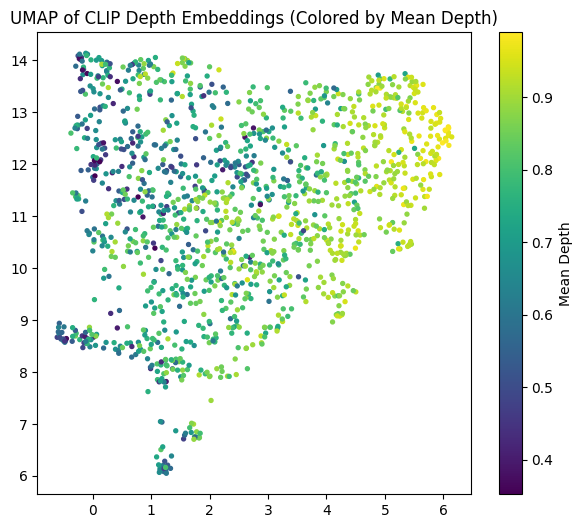

In [ ]:
# Colored by Mean Depth - Geometry
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

X_umap = umap_model.fit_transform(X_depth)

plt.figure(figsize=(7, 6))
plt.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    c=mean_depth,
    cmap="viridis",
    s=8
)
plt.colorbar(label="Mean Depth")
plt.title("UMAP of CLIP Depth Embeddings (Colored by Mean Depth)")
plt.show()

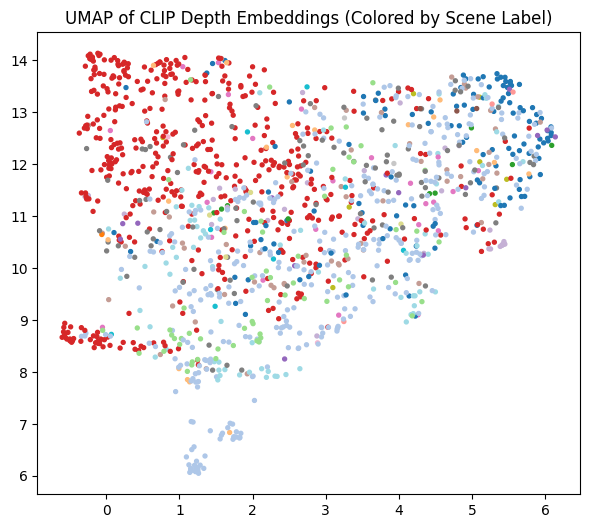

In [ ]:
# Colored by Scene Label - Semantics
unique_labels = np.unique(labels)
label_to_id = {l: i for i, l in enumerate(unique_labels)}
label_ids = np.array([label_to_id[l] for l in labels])

plt.figure(figsize=(7, 6))
plt.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    c=label_ids,
    cmap="tab20",
    s=8
)
plt.title("UMAP of CLIP Depth Embeddings (Colored by Scene Label)")
plt.show()

### t-SNE Visualization

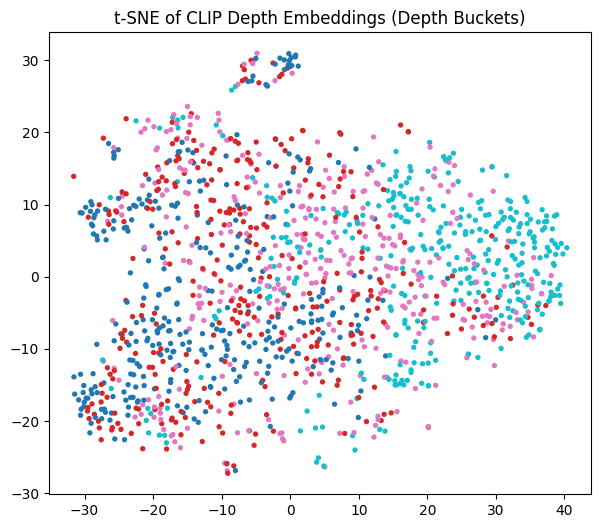

In [ ]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    metric="cosine",
    init="pca",
    random_state=42
)

X_tsne = tsne.fit_transform(X_depth)

plt.figure(figsize=(7, 6))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=depth_bucket,
    cmap="tab10",
    s=8
)
plt.title("t-SNE of CLIP Depth Embeddings (Depth Buckets)")
plt.show()

## Statistical Significance Testing

### Bootstrap Confidence Intervals - Pearson/Spearman Correlation

In [ ]:
def bootstrap_correlation(x, y, n_boot=1000, method="pearson"):
    """
    Bootstrap confidence intervals for correlation.
    """
    stats = []
    n = len(x)

    for _ in range(n_boot):
        idx = np.random.choice(n, n, replace=True)
        if method == "pearson":
            stats.append(pearsonr(x[idx], y[idx])[0])
        else:
            stats.append(spearmanr(x[idx], y[idx])[0])

    stats = np.array(stats)
    return {
        "mean": stats.mean(),
        "ci_2.5": np.percentile(stats, 2.5),
        "ci_97.5": np.percentile(stats, 97.5)
    }

In [ ]:
def permutation_test(x, y, n_perm=1000, method="pearson"):
    """
    Permutation test for correlation significance.
    """
    if method == "pearson":
        observed = pearsonr(x, y)[0]
    else:
        observed = spearmanr(x, y)[0]

    permuted = []

    for _ in range(n_perm):
        y_perm = np.random.permutation(y)
        if method == "pearson":
            permuted.append(pearsonr(x, y_perm)[0])
        else:
            permuted.append(spearmanr(x, y_perm)[0])

    permuted = np.array(permuted)
    p_value = np.mean(np.abs(permuted) >= np.abs(observed))

    return observed, p_value


In [ ]:
print("=== Bootstrap CI: CLIP vs Depth Histogram ===")
print(bootstrap_correlation(
    clip_sims,
    hist_sims,
    method="spearman"
))

=== Bootstrap CI: CLIP vs Depth Histogram ===
{'mean': np.float64(0.22095957936006316), 'ci_2.5': np.float64(0.1857298246323672), 'ci_97.5': np.float64(0.25680444204964314)}


In [ ]:
obs, p = permutation_test(
    clip_sims,
    hist_sims,
    method="spearman"
)

print("Observed Spearman:", obs)
print("Permutation p-value:", p)

Observed Spearman: 0.22107761300516127
Permutation p-value: 0.0


In [ ]:
label = label_results.iloc[0]["label"]
clip_l, stats_l, hist_l = label_conditioned_pairwise_analysis(df, label)

print("Within-label permutation test:")
print(permutation_test(clip_l, hist_l, method="spearman"))

Within-label permutation test:
(np.float64(0.1658574678465314), np.float64(0.0))


## Cross-Modal Alignment Analysis (RGB - Depth)
Are depth embeddings aligned with RGB embeddings in CLIP space?

In [ ]:
def rgb_depth_alignment(df):
    sims = []

    for _, row in df.iterrows():
        sim = cosine_similarity(
            row["image_embedding"][None],
            row["depthmap_embedding"][None]
        )[0, 0]
        sims.append(sim)

    return np.array(sims)

In [ ]:
def rgb_depth_random_alignment(df, n_samples=5000):
    sims = []
    idx = np.random.choice(len(df), n_samples, replace=True)

    for i in idx:
        j = np.random.randint(len(df))
        sim = cosine_similarity(
            df.iloc[i]["image_embedding"][None],
            df.iloc[j]["depthmap_embedding"][None]
        )[0, 0]
        sims.append(sim)

    return np.array(sims)

In [ ]:
paired_sims = rgb_depth_alignment(df)

print("Mean RGB–Depth similarity:", paired_sims.mean())
print("Std:", paired_sims.std())

Mean RGB–Depth similarity: 0.6116267575902761
Std: 0.06272585570352043


In [ ]:
random_sims = rgb_depth_random_alignment(df)

print("Random RGB–Depth similarity:", random_sims.mean())

Random RGB–Depth similarity: 0.5787931522063844


In [ ]:
# Statistical Test: Paired vs Random
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(paired_sims, random_sims, equal_var=False)

print("t-test p-value:", p_val)

t-test p-value: 8.403110808791088e-64


### Cross-Modal Retrieval Accuracy
Can RGB retrieve its corresponding depth?

In [ ]:
def cross_modal_retrieval(df, k=5):
    rgb = np.stack(df["image_embedding"].values)
    depth = np.stack(df["depthmap_embedding"].values)

    sim = cosine_similarity(rgb, depth)

    hits = []
    for i in range(len(df)):
        nn = np.argsort(-sim[i])[:k]
        hits.append(i in nn)

    return np.mean(hits)

In [ ]:
print("RGB → Depth Recall@5:", cross_modal_retrieval(df, k=5))

RGB → Depth Recall@5: 0.053429602888086646


### Geometry-Aware Cross-Modal Control

In [ ]:
def bucketed_cross_modal(df, k=5):
    acc = []

    for bucket in df["depth_bucket"].unique():
        subset = df[df["depth_bucket"] == bucket]
        if len(subset) < k:
            continue
        acc.append(cross_modal_retrieval(subset, k))

    return np.mean(acc)

In [ ]:
print("Bucketed RGB–Depth Recall@5:", bucketed_cross_modal(df))

Bucketed RGB–Depth Recall@5: 0.10540179240725625


## Comparing UMAPs Across Depth Encoders
Does CLIP organize depth embeddings geometrically as well as depth-native encoders?

In [ ]:
import umap
import matplotlib.pyplot as plt

def run_umap(embeddings, random_state=42):
  if embeddings.ndim == 1:
      embeddings = embeddings.reshape(-1, 1)
  reducer = umap.UMAP(
      n_neighbors=15,
      min_dist=0.1,
      metric="cosine",
      random_state=random_state
  )
  return reducer.fit_transform(embeddings)

### UMAP: CLIP vs DPT vs Depth-MAE

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/NNDL Project/sunrgbd_depth_embeddings.csv")
df["depthmap_embedding"] = df["depthmap_embedding"].apply(parse_embedding)
df["image_embedding"] = df["image_embedding"].apply(parse_embedding)

models = {
    "CLIP Depth": np.stack(df["depthmap_embedding"].values),
    "DPT Encoder": np.stack(df["dpt_embedding"].values),
    "Depth-MAE": np.stack(df["mae_embedding"].values),
    "DepthAnythingV2": np.stack(df["depthanythingv2_embedding"].values),
}

In [ ]:
import numpy as np
import pandas as pd
import re

def force_to_float_array(emb):
    """
    Converts embeddings that may be:
    - list of strings
    - pandas Series of strings
    - numpy array of dtype object / string
    into a clean float32 numpy array (N, D)
    """

    # If already a numeric numpy array → done
    if isinstance(emb, np.ndarray) and emb.dtype.kind in {"f", "i"}:
        return emb.astype(np.float32)

    # Convert to pandas Series for uniform handling
    if isinstance(emb, np.ndarray):
        emb = pd.Series(emb)
    elif isinstance(emb, list):
        emb = pd.Series(emb)

    # Parse each row manually (faster + safer than ast)
    def parse_row(x):
        if isinstance(x, (list, np.ndarray)):
            return np.array(x, dtype=np.float32)

        # Remove brackets and split on whitespace
        x = re.sub(r"[\[\]]", "", x)
        return np.fromstring(x, sep=" ", dtype=np.float32)

    parsed = emb.apply(parse_row)

    # Stack into (N, D)
    return np.vstack(parsed.values)

🔄 Found existing mean depth cache. Resuming...
Starting mean_depth computation...
  Processed 50/1385 depth maps
  Processed 100/1385 depth maps
  Processed 150/1385 depth maps
  Processed 200/1385 depth maps
  Processed 250/1385 depth maps
  Processed 300/1385 depth maps
  Processed 350/1385 depth maps
  Processed 400/1385 depth maps
  Processed 450/1385 depth maps
  Processed 500/1385 depth maps
  Processed 550/1385 depth maps
  Processed 600/1385 depth maps
  Processed 650/1385 depth maps
  Processed 700/1385 depth maps
  Processed 750/1385 depth maps
  Processed 800/1385 depth maps
  Processed 850/1385 depth maps
  Processed 900/1385 depth maps
  Processed 950/1385 depth maps
  Processed 1000/1385 depth maps
  Processed 1050/1385 depth maps
  Processed 1100/1385 depth maps
  Processed 1150/1385 depth maps
  Processed 1200/1385 depth maps
  Processed 1250/1385 depth maps
  Processed 1300/1385 depth maps
  Processed 1350/1385 depth maps
Finished mean_depth in 0.05s
Running UMAP for m

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  UMAP done in 5.01s
Running UMAP for model: DPT Encoder


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  UMAP done in 10.71s
Running UMAP for model: Depth-MAE


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  UMAP done in 5.66s
Running UMAP for model: DepthAnythingV2


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  UMAP done in 5.02s
Rendering plot...


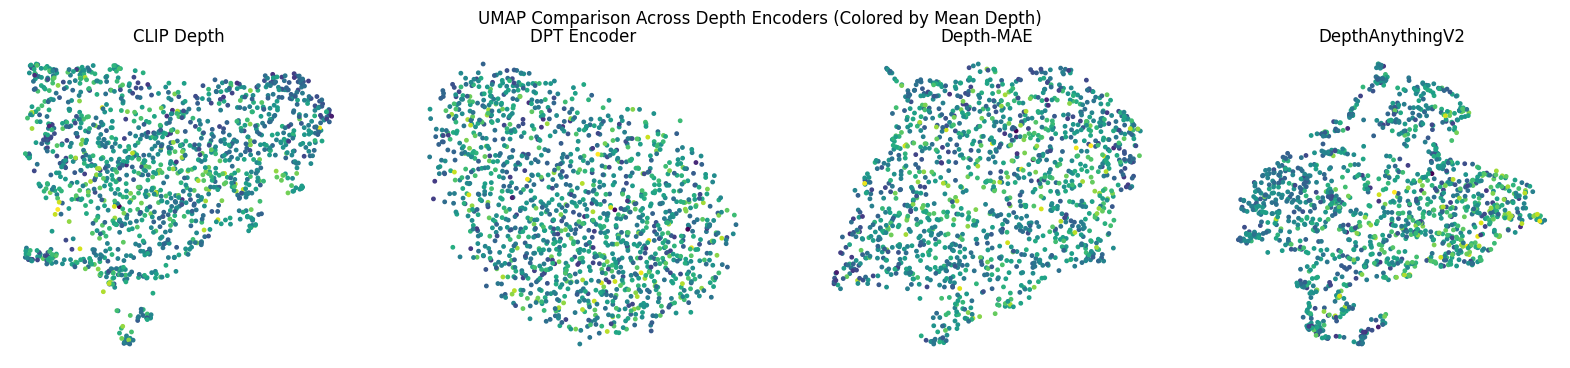

Done.


In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# ================= CONFIG =================
CACHE_PATH = "mean_depth_cache.csv"   # checkpoint file
SAVE_EVERY = 1                         # save after every image (safest)
# ==========================================

# ---------------- Load cache if it exists ----------------
if os.path.exists(CACHE_PATH):
    print("🔄 Found existing mean depth cache. Resuming...")
    cache_df = pd.read_csv(CACHE_PATH)
    depth_cache = dict(zip(cache_df["depthmap"], cache_df["mean_depth"]))
else:
    print("🆕 No cache found. Starting fresh.")
    depth_cache = {}

# ---------------- Mean depth computation ----------------
print("Starting mean_depth computation...")
t0 = time.time()

mean_depths = []
processed = 0

for idx, row in df.iterrows():
    depth_path = row["depthmap"]

    # If already computed, reuse
    if depth_path in depth_cache:
        mean_val = depth_cache[depth_path]
    else:
        try:
            mean_val = np.array(Image.open(depth_path)).mean()
        except Exception as e:
            print(f"⚠️ Failed on {depth_path}: {e}")
            mean_val = np.nan

        # Save progress immediately (checkpoint)
        pd.DataFrame(
            [(depth_path, mean_val)],
            columns=["depthmap", "mean_depth"]
        ).to_csv(
            CACHE_PATH,
            mode="a",
            header=not os.path.exists(CACHE_PATH),
            index=False
        )

        depth_cache[depth_path] = mean_val

    mean_depths.append(mean_val)
    processed += 1

    if processed % 50 == 0:
        print(f"  Processed {processed}/{len(df)} depth maps")

df["mean_depth"] = mean_depths

print(f"Finished mean_depth in {time.time() - t0:.2f}s")

mean_depth = df["mean_depth"].values

# ================== UMAP PLOTTING ==================
plt.figure(figsize=(20, 4))

for i, (name, emb) in enumerate(models.items(), 1):
    print(f"Running UMAP for model: {name}")

    t1 = time.time()
    emb = force_to_float_array(emb)
    X_umap = run_umap(emb)

    print(f"  UMAP done in {time.time() - t1:.2f}s")

    plt.subplot(1, 4, i)
    plt.scatter(
        X_umap[:, 0],
        X_umap[:, 1],
        c=mean_depth,
        cmap="viridis",
        s=6
    )
    plt.title(name)
    plt.axis("off")

print("Rendering plot...")
plt.suptitle("UMAP Comparison Across Depth Encoders (Colored by Mean Depth)")
plt.show()
print("Done.")


### UMAP: Semantic Coloring

Starting label factorization...
Labels factorized: 1385 labels
Creating figure...

Running UMAP for model 1/4: CLIP Depth
Embedding shape: (1385, 512)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP completed for CLIP Depth, output shape: (1385, 2)

Running UMAP for model 2/4: DPT Encoder
Embedding shape: (1385,)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP completed for DPT Encoder, output shape: (1385, 2)

Running UMAP for model 3/4: Depth-MAE
Embedding shape: (1385,)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP completed for Depth-MAE, output shape: (1385, 2)

Running UMAP for model 4/4: DepthAnythingV2
Embedding shape: (1385,)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP completed for DepthAnythingV2, output shape: (1385, 2)

Finalizing plot...


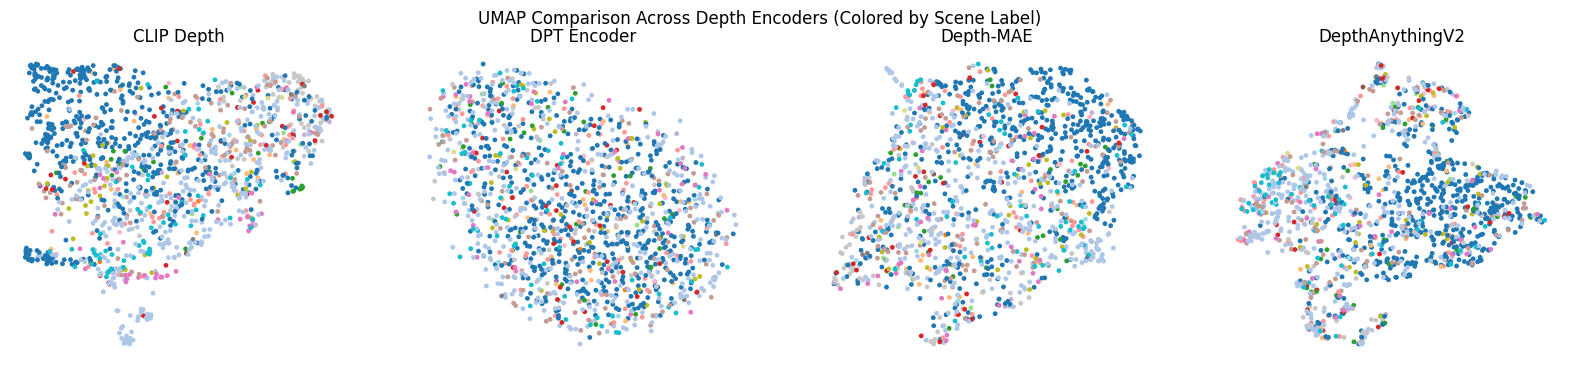

Done.


In [ ]:
print("Starting label factorization...")
label_ids = pd.factorize(df["label"])[0]
print(f"Labels factorized: {len(label_ids)} labels")

print("Creating figure...")
plt.figure(figsize=(20, 4))

for i, (name, emb) in enumerate(models.items(), 1):
    print(f"\nRunning UMAP for model {i}/{len(models)}: {name}")
    print(f"Embedding shape: {emb.shape}")

    emb = force_to_float_array(emb)
    X_umap = run_umap(emb)
    print(f"UMAP completed for {name}, output shape: {X_umap.shape}")

    plt.subplot(1, 4, i)
    plt.scatter(
        X_umap[:, 0],
        X_umap[:, 1],
        c=label_ids,
        cmap="tab20",
        s=6
    )
    plt.title(name)
    plt.axis("off")

print("\nFinalizing plot...")
plt.suptitle("UMAP Comparison Across Depth Encoders (Colored by Scene Label)")
plt.show()
print("Done.")


In [ ]:
def depth_embedding_correlation(
    embeddings,
    depth_hists,
    n_pairs=5000
):
    print("Starting depth_embedding_correlation...")
    print(f"Number of embeddings: {len(embeddings)}")
    print(f"Number of depth histograms: {len(depth_hists)}")
    print(f"Sampling {n_pairs} random pairs")

    idx = np.random.choice(len(embeddings), size=(n_pairs, 2), replace=True)
    print("Random index pairs generated")

    emb_sims = []
    depth_sims = []

    for k, (i, j) in enumerate(idx, 1):
        if k % 500 == 0:
            print(f"Processed {k}/{n_pairs} pairs")

        emb_sims.append(
            cosine_similarity(
                embeddings[i][None],
                embeddings[j][None]
            )[0, 0]
        )

        depth_sims.append(
            cosine_similarity(
                depth_hists[i][None],
                depth_hists[j][None]
            )[0, 0]
        )

    print("Computing Spearman correlation...")
    corr = spearmanr(emb_sims, depth_sims)[0]
    print(f"Correlation computed: {corr}")

    print("depth_embedding_correlation finished")
    return corr


In [ ]:
import numpy as np
import pandas as pd
import re

def force_2d_float_embeddings(emb):
    """
    Returns emb as a numeric np.ndarray with shape (N, D).
    Handles:
      - np.ndarray (N,) -> reshapes to (N,1)
      - pd.Series of floats -> (N,1)
      - pd.Series/list of strings like "[0.1 0.2 ...]" -> (N,D)
      - np.ndarray of dtype object containing lists/arrays -> stacks to (N,D)
    """
    # If pandas Series, get values
    if isinstance(emb, pd.Series):
        emb = emb.values

    # If list, make array
    if isinstance(emb, list):
        emb = np.array(emb, dtype=object)

    # If already numeric 2D
    if isinstance(emb, np.ndarray) and emb.ndim == 2 and emb.dtype.kind in {"f", "i"}:
        return emb.astype(np.float32)

    # If numeric 1D (N,) -> reshape (N,1)
    if isinstance(emb, np.ndarray) and emb.ndim == 1 and emb.dtype.kind in {"f", "i"}:
        return emb.reshape(-1, 1).astype(np.float32)

    # If object array of arrays/lists -> stack
    if isinstance(emb, np.ndarray) and emb.dtype == object and len(emb) > 0:
        if isinstance(emb[0], (list, np.ndarray)):
            return np.vstack([np.array(x, dtype=np.float32) for x in emb])

    # If strings like "[...]" or with newlines -> parse each row
    if isinstance(emb, np.ndarray) and emb.dtype.kind in {"U", "S", "O"}:
        def parse_row(x):
            if isinstance(x, (list, np.ndarray)):
                return np.array(x, dtype=np.float32)
            x = str(x)
            x = re.sub(r"[\[\]]", "", x)      # remove brackets
            x = x.replace("\n", " ")          # remove newlines
            return np.fromstring(x, sep=" ", dtype=np.float32)

        parsed = [parse_row(x) for x in emb]

        # If it parsed scalars, make them (N,1)
        if parsed and parsed[0].ndim == 0 or (parsed and parsed[0].shape == ()):
            return np.array(parsed, dtype=np.float32).reshape(-1, 1)

        return np.vstack(parsed)

    raise ValueError("Could not convert embeddings to a numeric 2D array.")

In [ ]:
print(df.columns.tolist())

depth_hists = np.stack(df["depth_hist"].values)

for name, emb in models.items():
  emb2d = force_2d_float_embeddings(emb)
  rho = depth_embedding_correlation(emb2d, depth_hists)
  print(f"{name}: Spearman ρ = {rho:.3f}")

['image', 'depthmap', 'caption', 'image_embedding', 'depthmap_embedding', 'caption_embedding', 'label', 'dpt_embedding', 'mae_embedding', 'depthanythingv2_embedding', 'mean_depth', 'depth_stats', 'depth_hist']
Starting depth_embedding_correlation...
Number of embeddings: 1385
Number of depth histograms: 1385
Sampling 5000 random pairs
Random index pairs generated
Processed 500/5000 pairs
Processed 1000/5000 pairs
Processed 1500/5000 pairs
Processed 2000/5000 pairs
Processed 2500/5000 pairs
Processed 3000/5000 pairs
Processed 3500/5000 pairs
Processed 4000/5000 pairs
Processed 4500/5000 pairs
Processed 5000/5000 pairs
Computing Spearman correlation...
Correlation computed: 0.2290622703129332
depth_embedding_correlation finished
CLIP Depth: Spearman ρ = 0.229
Starting depth_embedding_correlation...
Number of embeddings: 1385
Number of depth histograms: 1385
Sampling 5000 random pairs
Random index pairs generated
Processed 500/5000 pairs
Processed 1000/5000 pairs
Processed 1500/5000 pairs

/tmp/ipython-input-840129066.py:36: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = spearmanr(emb_sims, depth_sims)[0]


Starting depth_embedding_correlation...
Number of embeddings: 1385
Number of depth histograms: 1385
Sampling 5000 random pairs
Random index pairs generated
Processed 500/5000 pairs
Processed 1000/5000 pairs
Processed 1500/5000 pairs
Processed 2000/5000 pairs
Processed 2500/5000 pairs
Processed 3000/5000 pairs
Processed 3500/5000 pairs
Processed 4000/5000 pairs
Processed 4500/5000 pairs
Processed 5000/5000 pairs
Computing Spearman correlation...
Correlation computed: 0.34376792404749584
depth_embedding_correlation finished
Depth-MAE: Spearman ρ = 0.344
Starting depth_embedding_correlation...
Number of embeddings: 1385
Number of depth histograms: 1385
Sampling 5000 random pairs
Random index pairs generated
Processed 500/5000 pairs
Processed 1000/5000 pairs
Processed 1500/5000 pairs
Processed 2000/5000 pairs
Processed 2500/5000 pairs
Processed 3000/5000 pairs
Processed 3500/5000 pairs
Processed 4000/5000 pairs
Processed 4500/5000 pairs
Processed 5000/5000 pairs
Computing Spearman correlat